In [1]:
#imports
import pandas as pd 
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import time

import nba_api
from nba_api.stats.static import teams, players
from nba_api.stats.endpoints import playercareerstats, leaguegamefinder, playerdashboardbyclutch, playergamelogs, commonplayerinfo, teamplayeronoffdetails, teamgamelogs


In [2]:
#team abreviations and corresponding codes for data proccessing
team_abbreviations = {
    "ATL": 1,
    "BKN": 2,
    "BOS": 3,
    "CHA": 4,
    "CHI": 5,
    "CLE": 6,
    "DAL": 7,	
    "DEN": 8,
    "DET": 9,
    "GSW": 10,	
    "HOU": 11,	
    "IND": 12,
    "LAC": 13,	
    "LAL": 14,	
    "MEM": 15, 	
    "MIA": 16,	
    "MIL": 17,	
    "MIN": 18,	
    "NOP": 19,
    "NOH": 19,	
    "NYK": 20,	
    "OKC": 21,	
    "ORL": 22,	
    "PHI": 23,	
    "PHX": 24,	
    "POR": 25,	
    "SAC": 26,	
    "SAS": 27,	
    "TOR": 28,	
    "UTA": 29,	
    "WAS": 30
}

In [66]:
class Team(object):
    def __init__(self, TeamID):
        
        self.TeamID =  TeamID 
        self.TeamName = teams.find_team_name_by_id(team_id=self.TeamID)['full_name']

        self.StartYear = 2009 #First year data is avalible
        self.LastYear = 2021 #Current year
        
    #Complile the Team Data
    def compile_active_team_data(self):
        
        points_scored_raw_data=[]
        matchup_raw_data = []
        location = []
        #team_season_point_average_raw_data = []
        #opponent_team_season_point_average_raw_data = []
        game_date_raw_data = []
        team_season_point_average_api_data = []
        team_season_point_average_raw_data = []
        team_season_points_raw_data = []
        opponent_season_point_average_raw_data = []
        opponent_season_points_average_api_data = []
        opponent_season_points_raw_data = []
        
        
        print(self.StartYear, self.LastYear)
        for year in range((self.StartYear), (self.LastYear)):
            print("-------------------------------------------------")
            season = str(year) + "-" + str(((year+1)-2000))
            teamLogs = teamgamelogs.TeamGameLogs(team_id_nullable=self.TeamID, season_nullable=season)
            print(season)
            

            points_scored_api_data=teamLogs.get_data_frames()[0]["PTS"]
            matchup_api_data = teamLogs.get_data_frames()[0]["MATCHUP"]
            team_season_points_api_data=teamLogs.get_data_frames()[0]["PTS"]
            game_date_api_data = teamLogs.get_data_frames()[0]["GAME_DATE"]
        

            print(teamLogs.get_data_frames()[0])


            season_team_points = []
            opponent_season_points = []
            for game in range(0, len(teamLogs.get_data_frames()[0])):
        
                    game_date_raw_data.append(game_date_api_data[game][:4])
                    
                    points_scored_raw_data.append(points_scored_api_data[game])
                    team_season_points_raw_data.append(team_season_points_api_data[game])
                    season_team_points.append(team_season_points_api_data[game])
                    if game == 0:
                        team_season_point_average_raw_data.append(teamLogs.get_data_frames()[0]["PTS"][game])
                    else:
                        team_season_point_average_raw_data.append((sum(season_team_points)/len(season_team_points)))
                        
                        
                    team_abbreviation= teams.find_team_name_by_id(team_id=self.TeamID)['abbreviation']
                    matchup_api_data[game] = matchup_api_data[game].replace('NOH', 'NOP')
                    matchup_api_data[game] = matchup_api_data[game].replace('NJN', 'BKN')
                
                    if " vs. " in matchup_api_data[game]:
                        location.append(1)
                    elif "@" in matchup_api_data[game]:
                        location.append(2)

                    try:   
                        
                        matchup_api_data[game] = matchup_api_data[game].replace(team_abbreviation, "")
                        
                    except:
                        print("Unexpected Error with removing player team")
                    try:
                        matchup_api_data[game] = matchup_api_data[game].replace(" @ ", "")
                        matchup_api_data[game] = matchup_api_data[game].replace(" vs. ", "")
                    except:
                        print("Error")
                    
                    
                    
                    opponentAbbreviation = matchup_api_data[game]
                    matchup_api_data[game] = team_abbreviations[opponentAbbreviation]
                    matchup_raw_data.append(matchup_api_data[game])
                    opponentID = int(teams.find_team_by_abbreviation(opponentAbbreviation)["id"])
                    if (game%10==0):
                        print(game)
                        
                    opponentLogs = teamgamelogs.TeamGameLogs(team_id_nullable=opponentID, season_nullable=season)
                    opponent_season_points_api_data = opponentLogs.get_data_frames()[0]['PTS']
                    if game == 0:
                        opponent_season_point_average_raw_data.append(opponent_season_points_api_data[game])
                    elif game<(len(opponentLogs.get_data_frames()[0]['PTS'])):
                        opponent_season_point_average_raw_data.append(opponent_season_points_api_data.head(game).mean())
                    else:
                        opponent_season_point_average_raw_data.append(opponent_season_points_api_data.mean())
                                            
                    time.sleep(1)
                    

        #Lengths of lists used for troublshooting
        print("the lengths")
        print(len(points_scored_raw_data))
        print(len(matchup_raw_data))
        print(len(team_season_point_average_raw_data))
        print(len(opponent_season_point_average_raw_data))
        print(len(location))
        
        #adding the lists to the team data dictionary to be made into a dataframe
        #Commented out lists that I am testing without
        team_data = {
        #"Player Name": player_name,
        "Points Scored": points_scored_raw_data,
        "Game Date": game_date_raw_data,
        #"MIN Played": min_played_raw_data,
        #"Win/Loss": win_loss_raw_data,
        #"Free Throws": free_throws_raw_data,
        #"Feild Goals 2pts": feild_goals_2pts_raw_data,
        #"Feild Goals 3pts": feild_goals_3pts_raw_data,
        "Matchup": matchup_raw_data,
        #"Location": location,
        "Team Point Average" : team_season_point_average_raw_data,
        "Opponent Team Point Average": opponent_season_point_average_raw_data 
        }

        team_dataFrame = pd.DataFrame(data=team_data)
        print(team_dataFrame) #print for troublshooting

        return(team_dataFrame)


    #Get the Team data for outside calls
    def get_active_team_data(self):
        return(self.compile_active_team_data())



In [69]:
#Data Preparation

#Test is being done with the Brooklyn Nets ID: 1610612751
test = Team(1610612751).get_active_team_data() #test is the dataframe 



#Data processing
    
opponent = test.pop('Matchup')

test["ATL"] = (opponent == 1)*1.0
test["BKN"] = (opponent == 2)*1.0
test["BOS"] = (opponent == 3)*1.0
test["CHA"] = (opponent == 4)*1.0
test["CHI"] = (opponent == 5)*1.0
test["CLE"] = (opponent == 6)*1.0
test["DAL"] = (opponent == 7)*1.0
test["DEN"] = (opponent == 8)*1.0
test["DET"] = (opponent == 9)*1.0
test["GSW"] = (opponent == 10)*1.0
test["HOU"] = (opponent == 11)*1.0
test["IND"] = (opponent == 12)*1.0
test["LAC"] = (opponent == 13)*1.0
test["LAL"] = (opponent == 14)*1.0
test["MEM"] = (opponent == 15)*1.0
test["MIA"] = (opponent == 16)*1.0
test["MIL"] = (opponent == 17)*1.0
test["MIN"] = (opponent == 18)*1.0
test["NOP"] = (opponent == 19)*1.0
test["NYK"] = (opponent == 20)*1.0
test["OKC"] = (opponent == 21)*1.0
test["ORL"] = (opponent == 22)*1.0
test["PHI"] = (opponent == 23)*1.0
test["PHX"] = (opponent == 24)*1.0
test["POR"] = (opponent == 25)*1.0
test["SAC"] = (opponent == 26)*1.0
test["SAS"] = (opponent == 27)*1.0
test["TOR"] = (opponent == 28)*1.0
test["UTA"] = (opponent == 29)*1.0
test["WAS"] = (opponent == 30)*1.0		


test = test.drop(columns=["BKN"])


test["Game Date"] = test["Game Date"].replace(2010, 1)
test["Game Date"] = test["Game Date"].replace(2011, 2)
test["Game Date"] = test["Game Date"].replace(2012, 3)
test["Game Date"] = test["Game Date"].replace(2013, 4)
test["Game Date"] = test["Game Date"].replace(2014, 5)
test["Game Date"] = test["Game Date"].replace(2015, 6)
test["Game Date"] = test["Game Date"].replace(2016, 7)
test["Game Date"] = test["Game Date"].replace(2017, 8)
test["Game Date"] = test["Game Date"].replace(2018, 9)
test["Game Date"] = test["Game Date"].replace(2019, 10)
test["Game Date"] = test["Game Date"].replace(2020, 11)
test["Game Date"] = test["Game Date"].replace(2021, 12)

year_fix = test.pop('Game Date')

test["2010"] = (year_fix == 1)*1.0
test["2011"] = (year_fix == 2)*1.0
test["2012"] = (year_fix == 3)*1.0
test["2013"] = (year_fix == 4)*1.0
test["2014"] = (year_fix == 5)*1.0
test["2015"] = (year_fix == 6)*1.0
test["2016"] = (year_fix == 7)*1.0
test["2017"] = (year_fix == 8)*1.0
test["2018"] = (year_fix == 9)*1.0
test["2019"] = (year_fix == 10)*1.0
test["2020"] = (year_fix == 11)*1.0
test["2021"] = (year_fix == 11)*1.0

print(test)




2009 2021
-------------------------------------------------
2009-10
   SEASON_YEAR     TEAM_ID TEAM_ABBREVIATION        TEAM_NAME     GAME_ID  \
0      2009-10  1610612751               NJN  New Jersey Nets  0020901222   
1      2009-10  1610612751               NJN  New Jersey Nets  0020901205   
2      2009-10  1610612751               NJN  New Jersey Nets  0020901188   
3      2009-10  1610612751               NJN  New Jersey Nets  0020901181   
4      2009-10  1610612751               NJN  New Jersey Nets  0020901162   
..         ...         ...               ...              ...         ...   
77     2009-10  1610612751               NJN  New Jersey Nets  0020900063   
78     2009-10  1610612751               NJN  New Jersey Nets  0020900046   
79     2009-10  1610612751               NJN  New Jersey Nets  0020900032   
80     2009-10  1610612751               NJN  New Jersey Nets  0020900027   
81     2009-10  1610612751               NJN  New Jersey Nets  0020900011   

       

10
20
30
40
50
60
-------------------------------------------------
2012-13
   SEASON_YEAR     TEAM_ID TEAM_ABBREVIATION      TEAM_NAME     GAME_ID  \
0      2012-13  1610612751               BKN  Brooklyn Nets  0021201217   
1      2012-13  1610612751               BKN  Brooklyn Nets  0021201205   
2      2012-13  1610612751               BKN  Brooklyn Nets  0021201195   
3      2012-13  1610612751               BKN  Brooklyn Nets  0021201178   
4      2012-13  1610612751               BKN  Brooklyn Nets  0021201168   
..         ...         ...               ...            ...         ...   
77     2012-13  1610612751               BKN  Brooklyn Nets  0021200090   
78     2012-13  1610612751               BKN  Brooklyn Nets  0021200069   
79     2012-13  1610612751               BKN  Brooklyn Nets  0021200056   
80     2012-13  1610612751               BKN  Brooklyn Nets  0021200043   
81     2012-13  1610612751               BKN  Brooklyn Nets  0021200029   

              GAME_DATE

10
20
30
40
50
60
70
80
-------------------------------------------------
2015-16
   SEASON_YEAR     TEAM_ID TEAM_ABBREVIATION      TEAM_NAME     GAME_ID  \
0      2015-16  1610612751               BKN  Brooklyn Nets  0021501218   
1      2015-16  1610612751               BKN  Brooklyn Nets  0021501206   
2      2015-16  1610612751               BKN  Brooklyn Nets  0021501199   
3      2015-16  1610612751               BKN  Brooklyn Nets  0021501178   
4      2015-16  1610612751               BKN  Brooklyn Nets  0021501167   
..         ...         ...               ...            ...         ...   
77     2015-16  1610612751               BKN  Brooklyn Nets  0021500062   
78     2015-16  1610612751               BKN  Brooklyn Nets  0021500047   
79     2015-16  1610612751               BKN  Brooklyn Nets  0021500036   
80     2015-16  1610612751               BKN  Brooklyn Nets  0021500028   
81     2015-16  1610612751               BKN  Brooklyn Nets  0021500006   

              GAM

10
20
30
40
50
60
70
80
-------------------------------------------------
2018-19
   SEASON_YEAR     TEAM_ID TEAM_ABBREVIATION      TEAM_NAME     GAME_ID  \
0      2018-19  1610612751               BKN  Brooklyn Nets  0021801221   
1      2018-19  1610612751               BKN  Brooklyn Nets  0021801199   
2      2018-19  1610612751               BKN  Brooklyn Nets  0021801193   
3      2018-19  1610612751               BKN  Brooklyn Nets  0021801169   
4      2018-19  1610612751               BKN  Brooklyn Nets  0021801154   
..         ...         ...               ...            ...         ...   
77     2018-19  1610612751               BKN  Brooklyn Nets  0021800072   
78     2018-19  1610612751               BKN  Brooklyn Nets  0021800053   
79     2018-19  1610612751               BKN  Brooklyn Nets  0021800026   
80     2018-19  1610612751               BKN  Brooklyn Nets  0021800018   
81     2018-19  1610612751               BKN  Brooklyn Nets  0021800004   

              GAM

10
20
30
the lengths
913
913
913
913
913
     Points Scored Game Date  Matchup  Team Point Average  \
0               86      2010       16           86.000000   
1               95      2010        4           90.500000   
2              102      2010       12           94.333333   
3              127      2010        5          102.500000   
4               89      2010       17           99.800000   
..             ...       ...      ...                 ...   
908            145      2020        1          121.757576   
909            111      2020       15          121.441176   
910            104      2020        4          120.942857   
911            123      2020        3          121.000000   
912            125      2020       10          121.108108   

     Opponent Team Point Average  
0                      94.000000  
1                      89.000000  
2                      97.500000  
3                     101.000000  
4                      96.750000  
..              

In [70]:
#Use this to delete columns as wanted
test = test.drop(columns=["2010","2011","2012","2013","2014","2015","2016","2017","2018","2019","2020","2021"]) #,"ATL", "BKN","BOS","CHA","CHI","CLE","DEN","DET","GSW","HOU","IND","LAC","LAL","MEM","MIA","MIL","MIN","NOP","NYK","OKC","ORL","PHI","PHX","POR","SAC","SAS","TOR","UTA","WAS"])

In [71]:
test #prints test data before format for training and testing

,Points Scored,Team Point Average,Opponent Team Point Average,ATL,BOS,CHA,CHI,CLE,DAL,DEN,...,OKC,ORL,PHI,PHX,POR,SAC,SAS,TOR,UTA,WAS
0,86,86.000000,94.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,95,90.500000,89.000000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,102,94.333333,97.500000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,127,102.500000,101.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,89,99.800000,96.750000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
908,145,121.757576,110.593750,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
909,111,121.441176,111.593750,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
910,104,120.942857,112.676471,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
911,123,121.000000,111.400000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


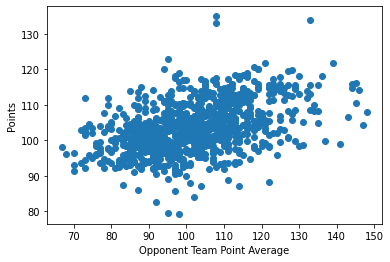

In [72]:
#This is used to visualize the relationships between the data 
import matplotlib.pyplot as plt

plt.figure()
plt.xlabel("Opponent Team Point Average")
plt.ylabel("Points")
plt.scatter(test["Points Scored"], test["Opponent Team Point Average"])

In [111]:
train_dataset = test.sample(frac=0.90, random_state=0)
test_dataset = test.drop(train_dataset.index)

In [112]:
#Print test dataset
test_dataset

,Points Scored,Team Point Average,Opponent Team Point Average,ATL,BOS,CHA,CHI,CLE,DAL,DEN,...,OKC,ORL,PHI,PHX,POR,SAC,SAS,TOR,UTA,WAS
9,83,99.100000,99.777778,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
28,84,96.586207,96.071429,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
42,95,94.441860,95.071429,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
47,89,94.291667,99.893617,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
53,99,93.944444,100.415094,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
850,109,111.659574,111.130435,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
852,108,111.387755,101.666667,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
862,101,111.186441,102.275862,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
880,127,122.000000,119.500000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [113]:
#Print train dataset
train_dataset

,Points Scored,Team Point Average,Opponent Team Point Average,ATL,BOS,CHA,CHI,CLE,DAL,DEN,...,OKC,ORL,PHI,PHX,POR,SAC,SAS,TOR,UTA,WAS
252,85,101.304348,94.590909,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
695,104,105.785714,104.527273,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
144,84,94.015873,92.774194,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
748,135,114.518519,108.153846,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
145,120,94.421875,105.285714,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
660,123,110.666667,113.450000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
143,75,94.177419,94.934426,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
180,102,94.882353,84.062500,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
131,81,95.080000,97.877551,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


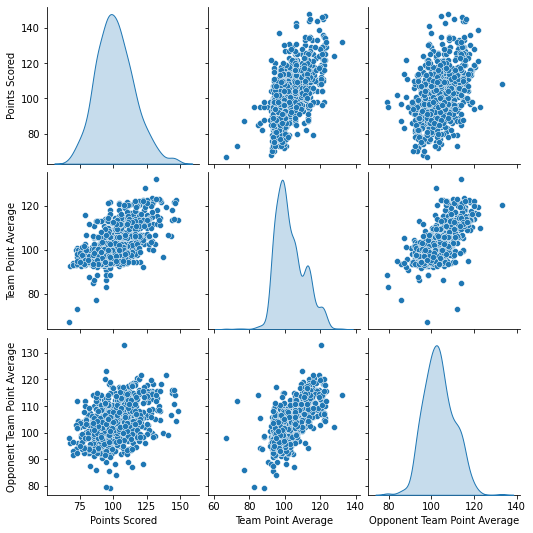

In [114]:
#Visualize relationships between the data
sns.pairplot(train_dataset[["Points Scored","Team Point Average", "Opponent Team Point Average"]], diag_kind="kde" )

In [115]:
#Print data stats
train_stats = train_dataset.describe()
train_stats.pop("Points Scored")
train_stats = train_stats.transpose()
train_stats


,count,mean,std,min,25%,50%,75%,max
Team Point Average,822.0,102.924182,8.150729,67.00,97.136461,100.860577,107.202841,132.0
Opponent Team Point Average,822.0,103.528352,7.051751,79.25,98.604010,103.012500,108.204762,133.0
ATL,822.0,0.046229,0.210108,0.00,0.000000,0.000000,0.000000,1.0
BOS,822.0,0.047445,0.212719,0.00,0.000000,0.000000,0.000000,1.0
CHA,822.0,0.045012,0.207457,0.00,0.000000,0.000000,0.000000,1.0
CHI,822.0,0.041363,0.199249,0.00,0.000000,0.000000,0.000000,1.0
CLE,822.0,0.041363,0.199249,0.00,0.000000,0.000000,0.000000,1.0
DAL,822.0,0.023114,0.150358,0.00,0.000000,0.000000,0.000000,1.0
DEN,822.0,0.024331,0.154168,0.00,0.000000,0.000000,0.000000,1.0
DET,822.0,0.043796,0.204765,0.00,0.000000,0.000000,0.000000,1.0


In [116]:
#Set up data labels
train_labels = train_dataset.pop("Points Scored")
test_labels = test_dataset.pop("Points Scored")

In [117]:
#print training labels
train_labels

252     85
695    104
144     84
748    135
145    120
      ... 
660    123
143     75
180    102
131     81
864    117
Name: Points Scored, Length: 822, dtype: int64

In [118]:
#print test labels
test_labels

9       83
28      84
42      95
47      89
53      99
      ... 
850    109
852    108
862    101
880    127
896    113
Name: Points Scored, Length: 91, dtype: int64

In [119]:
#print train labels
train_dataset

,Team Point Average,Opponent Team Point Average,ATL,BOS,CHA,CHI,CLE,DAL,DEN,DET,...,OKC,ORL,PHI,PHX,POR,SAC,SAS,TOR,UTA,WAS
252,101.304348,94.590909,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
695,105.785714,104.527273,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
144,94.015873,92.774194,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
748,114.518519,108.153846,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
145,94.421875,105.285714,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
660,110.666667,113.450000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
143,94.177419,94.934426,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
180,94.882353,84.062500,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
131,95.080000,97.877551,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [120]:
#normalize the data
def sigmoid(x):
    return(x - train_stats['mean'])/train_stats['std']
normed_train_data = sigmoid(train_dataset)
normed_test_data = sigmoid(test_dataset)


In [121]:
#print normed train data
normed_train_data

,Team Point Average,Opponent Team Point Average,ATL,BOS,CHA,CHI,CLE,DAL,DEN,DET,...,OKC,ORL,PHI,PHX,POR,SAC,SAS,TOR,UTA,WAS
252,-0.198735,-1.267408,-0.220024,-0.223042,-0.216971,4.811265,-0.207593,-0.153729,-0.157821,-0.213883,...,-0.161819,-0.223042,-0.237669,-0.161819,-0.149535,-0.157821,-0.157821,-0.226028,-0.157821,-0.220024
695,0.351077,0.141656,-0.220024,-0.223042,-0.216971,-0.207593,-0.207593,-0.153729,-0.157821,-0.213883,...,-0.161819,-0.223042,-0.237669,-0.161819,-0.149535,-0.157821,-0.157821,-0.226028,-0.157821,-0.220024
144,-1.092946,-1.525034,-0.220024,-0.223042,4.603304,-0.207593,-0.207593,-0.153729,-0.157821,-0.213883,...,-0.161819,-0.223042,-0.237669,-0.161819,-0.149535,-0.157821,-0.157821,-0.226028,-0.157821,-0.220024
748,1.422491,0.655936,-0.220024,-0.223042,-0.216971,-0.207593,-0.207593,-0.153729,6.328603,-0.213883,...,-0.161819,-0.223042,-0.237669,-0.161819,-0.149535,-0.157821,-0.157821,-0.226028,-0.157821,-0.220024
145,-1.043135,0.249209,-0.220024,-0.223042,-0.216971,-0.207593,-0.207593,-0.153729,-0.157821,-0.213883,...,6.172233,-0.223042,-0.237669,-0.161819,-0.149535,-0.157821,-0.157821,-0.226028,-0.157821,-0.220024
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
660,0.949913,1.406977,-0.220024,-0.223042,-0.216971,-0.207593,4.811265,-0.153729,-0.157821,-0.213883,...,-0.161819,-0.223042,-0.237669,-0.161819,-0.149535,-0.157821,-0.157821,-0.226028,-0.157821,-0.220024
143,-1.073126,-1.218694,-0.220024,4.478002,-0.216971,-0.207593,-0.207593,-0.153729,-0.157821,-0.213883,...,-0.161819,-0.223042,-0.237669,-0.161819,-0.149535,-0.157821,-0.157821,-0.226028,-0.157821,-0.220024
180,-0.986639,-2.760428,-0.220024,-0.223042,4.603304,-0.207593,-0.207593,-0.153729,-0.157821,-0.213883,...,-0.161819,-0.223042,-0.237669,-0.161819,-0.149535,-0.157821,-0.157821,-0.226028,-0.157821,-0.220024
131,-0.962390,-0.801333,-0.220024,-0.223042,-0.216971,4.811265,-0.207593,-0.153729,-0.157821,-0.213883,...,-0.161819,-0.223042,-0.237669,-0.161819,-0.149535,-0.157821,-0.157821,-0.226028,-0.157821,-0.220024


In [122]:
#print normed test data
normed_test_data

,Team Point Average,Opponent Team Point Average,ATL,BOS,CHA,CHI,CLE,DAL,DEN,DET,...,OKC,ORL,PHI,PHX,POR,SAC,SAS,TOR,UTA,WAS
9,-0.469183,-0.531864,-0.220024,-0.223042,-0.216971,4.811265,-0.207593,-0.153729,-0.157821,-0.213883,...,-0.161819,-0.223042,-0.237669,-0.161819,-0.149535,-0.157821,-0.157821,-0.226028,-0.157821,-0.220024
28,-0.777596,-1.057457,-0.220024,-0.223042,-0.216971,-0.207593,-0.207593,-0.153729,-0.157821,-0.213883,...,-0.161819,-0.223042,-0.237669,-0.161819,-0.149535,-0.157821,-0.157821,-0.226028,-0.157821,-0.220024
42,-1.040683,-1.199266,-0.220024,-0.223042,-0.216971,-0.207593,-0.207593,-0.153729,-0.157821,-0.213883,...,-0.161819,-0.223042,-0.237669,-0.161819,-0.149535,-0.157821,-0.157821,-0.226028,-0.157821,-0.220024
47,-1.059110,-0.515437,4.539436,-0.223042,-0.216971,-0.207593,-0.207593,-0.153729,-0.157821,-0.213883,...,-0.161819,-0.223042,-0.237669,-0.161819,-0.149535,-0.157821,-0.157821,-0.226028,-0.157821,-0.220024
53,-1.101710,-0.441487,-0.220024,-0.223042,-0.216971,-0.207593,-0.207593,-0.153729,-0.157821,-0.213883,...,-0.161819,-0.223042,-0.237669,-0.161819,-0.149535,-0.157821,-0.157821,-0.226028,-0.157821,-0.220024
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
850,1.071731,1.078042,-0.220024,-0.223042,-0.216971,-0.207593,-0.207593,-0.153729,-0.157821,-0.213883,...,-0.161819,-0.223042,4.202417,-0.161819,-0.149535,-0.157821,-0.157821,-0.226028,-0.157821,-0.220024
852,1.038382,-0.264003,-0.220024,-0.223042,4.603304,-0.207593,-0.207593,-0.153729,-0.157821,-0.213883,...,-0.161819,-0.223042,-0.237669,-0.161819,-0.149535,-0.157821,-0.157821,-0.226028,-0.157821,-0.220024
862,1.013683,-0.177614,-0.220024,-0.223042,4.603304,-0.207593,-0.207593,-0.153729,-0.157821,-0.213883,...,-0.161819,-0.223042,-0.237669,-0.161819,-0.149535,-0.157821,-0.157821,-0.226028,-0.157821,-0.220024
880,2.340382,2.264919,-0.220024,-0.223042,-0.216971,-0.207593,-0.207593,-0.153729,-0.157821,-0.213883,...,-0.161819,-0.223042,-0.237669,-0.161819,-0.149535,6.328603,-0.157821,-0.226028,-0.157821,-0.220024


In [123]:
#Defining the model
def build_model():
    #below comented out portion is another model under testing
    '''
    input_layer=tf.keras.layers.Input(([len(train_dataset.keys())]))
    densel_layer = tf.keras.layers.Dense(units=1, input_shape=([len(train_dataset.keys())],))
    output = densel_layer(input_layer)
    model = tf.keras.Model(inputs=input_layer,outputs=output)
    
    model.compile(loss="mse",optimizer=tf.keras.optimizers.Adam(0.1), metrics=['mae', 'mse'])
    
    '''
    
    print([len(train_dataset.keys())])
    model = keras.Sequential([
        
        layers.Dense(15, activation=tf.nn.relu, input_shape=[len(train_dataset.keys())]),
        layers.Dense(25, activation=tf.nn.relu),
        layers.Dense(1)
    ])

    optimizer = tf.keras.optimizers.RMSprop(0.001)

    model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
    
    
    return model

In [124]:
model = build_model()

[31]


In [125]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_27 (Dense)             (None, 15)                480       
_________________________________________________________________
dense_28 (Dense)             (None, 25)                400       
_________________________________________________________________
dense_29 (Dense)             (None, 1)                 26        
Total params: 906
Trainable params: 906
Non-trainable params: 0
_________________________________________________________________


In [126]:
#test predictions without any training 
example_batch = normed_train_data
print((example_batch.keys()))
example_result = model.predict(example_batch)
example_result

Index(['Team Point Average', 'Opponent Team Point Average', 'ATL', 'BOS',
       'CHA', 'CHI', 'CLE', 'DAL', 'DEN', 'DET', 'GSW', 'HOU', 'IND', 'LAC',
       'LAL', 'MEM', 'MIA', 'MIL', 'MIN', 'NOP', 'NYK', 'OKC', 'ORL', 'PHI',
       'PHX', 'POR', 'SAC', 'SAS', 'TOR', 'UTA', 'WAS'],
      dtype='object')


array([[-3.41946512e-01],
       [-1.49172440e-01],
       [-1.29806429e-01],
       [-1.21318817e+00],
       [-1.00917661e+00],
       [-7.78540015e-01],
       [-6.03380501e-01],
       [-8.80075753e-01],
       [-1.32898545e+00],
       [-4.52210456e-01],
       [-9.84587550e-01],
       [-7.14185357e-01],
       [-7.81706929e-01],
       [-4.89534587e-01],
       [-2.57662117e-01],
       [-4.84109402e-01],
       [-8.84178638e-01],
       [ 1.54876485e-01],
       [-5.72253287e-01],
       [-9.15462375e-01],
       [-3.18662971e-01],
       [-1.16536593e+00],
       [-1.16565287e+00],
       [-6.05477691e-01],
       [-2.94977218e-01],
       [-4.19159532e-01],
       [-2.35943422e-02],
       [-1.87427342e-01],
       [-4.36977774e-01],
       [-1.33696032e+00],
       [ 3.15381050e-01],
       [-6.16781294e-01],
       [-2.67936051e-01],
       [-3.24825138e-01],
       [-2.97528923e-01],
       [-4.63160157e-01],
       [-5.28840482e-01],
       [-7.60673106e-01],
       [-3.0

In [127]:
#training without early stopping
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0:
            print('')
        print('.', end='')
EPOCHS = 1000
history = model.fit(
    normed_train_data, train_labels,
    epochs=EPOCHS, callbacks=[PrintDot()])
'''history = model.fit(
    normed_train_data, train_labels,
    epochs=EPOCHS, validation_split= 0.2, verbose=0,
    callbacks=[PrintDot()])'''

Epoch 1/1000
26/26 [==============================] - 0s 918us/step - loss: 10508.7566 - mae: 101.5277 - mse: 10508.7566

.Epoch 2/1000
26/26 [==============================] - 0s 999us/step - loss: 10302.1502 - mae: 100.4412 - mse: 10302.1502
.Epoch 3/1000
26/26 [==============================] - 0s 957us/step - loss: 10102.9949 - mae: 99.5464 - mse: 10102.9949
.Epoch 4/1000
26/26 [==============================] - 0s 1ms/step - loss: 9850.4358 - mae: 98.3288 - mse: 9850.4358
.Epoch 5/1000
26/26 [==============================] - 0s 1ms/step - loss: 9390.4919 - mae: 95.9578 - mse: 9390.4919
.Epoch 6/1000
26/26 [==============================] - 0s 1ms/step - loss: 9031.0468 - mae: 94.0862 - mse: 9031.0468
.Epoch 7/1000
26/26 [==============================] - 0s 2ms/step - loss: 8627.6155 - mae: 91.7909 - mse: 8627.6155
.Epoch 8/1000
26/26 [==============================] - 0s 1ms/step - loss: 7913.4452 - mae: 87.8650 - mse: 7913.4452
.Epoch 9/1000
26/26 [=============================

26/26 [==============================] - 0s 958us/step - loss: 111.8718 - mae: 8.3247 - mse: 111.8718
.Epoch 71/1000
26/26 [==============================] - 0s 957us/step - loss: 128.7545 - mae: 8.9088 - mse: 128.7545
.Epoch 72/1000
26/26 [==============================] - 0s 878us/step - loss: 124.3746 - mae: 8.7304 - mse: 124.3746
.Epoch 73/1000
26/26 [==============================] - 0s 798us/step - loss: 112.9795 - mae: 8.4736 - mse: 112.9795
.Epoch 74/1000
26/26 [==============================] - 0s 878us/step - loss: 112.1808 - mae: 8.2363 - mse: 112.1808
.Epoch 75/1000
26/26 [==============================] - 0s 838us/step - loss: 114.7079 - mae: 8.4368 - mse: 114.7079
.Epoch 76/1000
26/26 [==============================] - 0s 838us/step - loss: 106.8124 - mae: 8.2099 - mse: 106.8124
.Epoch 77/1000
26/26 [==============================] - 0s 838us/step - loss: 112.6146 - mae: 8.3982 - mse: 112.6146
.Epoch 78/1000
26/26 [==============================] - 0s 838us/step - loss: 1

26/26 [==============================] - 0s 1ms/step - loss: 116.7380 - mae: 8.5179 - mse: 116.7380
.Epoch 141/1000
26/26 [==============================] - 0s 1ms/step - loss: 113.3542 - mae: 8.2540 - mse: 113.3542
.Epoch 142/1000
26/26 [==============================] - 0s 1ms/step - loss: 120.4686 - mae: 8.6235 - mse: 120.4686
.Epoch 143/1000
26/26 [==============================] - 0s 1ms/step - loss: 111.2170 - mae: 8.3243 - mse: 111.2170
.Epoch 144/1000
26/26 [==============================] - 0s 1ms/step - loss: 120.2983 - mae: 8.6186 - mse: 120.2983
.Epoch 145/1000
26/26 [==============================] - 0s 1ms/step - loss: 110.5769 - mae: 8.3342 - mse: 110.5769
.Epoch 146/1000
26/26 [==============================] - 0s 1ms/step - loss: 115.1809 - mae: 8.4212 - mse: 115.1809
.Epoch 147/1000
26/26 [==============================] - 0s 1ms/step - loss: 120.8664 - mae: 8.5641 - mse: 120.8664
.Epoch 148/1000
26/26 [==============================] - 0s 1ms/step - loss: 111.4852 - 

26/26 [==============================] - 0s 1ms/step - loss: 109.5167 - mae: 8.3245 - mse: 109.5167
.Epoch 211/1000
26/26 [==============================] - 0s 1ms/step - loss: 116.3356 - mae: 8.2264 - mse: 116.3356
.Epoch 212/1000
26/26 [==============================] - 0s 979us/step - loss: 114.8508 - mae: 8.3366 - mse: 114.8508
.Epoch 213/1000
26/26 [==============================] - 0s 1ms/step - loss: 109.7122 - mae: 8.1937 - mse: 109.7122
.Epoch 214/1000
26/26 [==============================] - 0s 1ms/step - loss: 119.7328 - mae: 8.5059 - mse: 119.7328
.Epoch 215/1000
26/26 [==============================] - 0s 920us/step - loss: 115.9258 - mae: 8.4879 - mse: 115.9258
.Epoch 216/1000
26/26 [==============================] - 0s 1ms/step - loss: 111.4644 - mae: 8.2049 - mse: 111.4644
.Epoch 217/1000
26/26 [==============================] - 0s 2ms/step - loss: 121.2233 - mae: 8.5930 - mse: 121.2233
.Epoch 218/1000
26/26 [==============================] - 0s 2ms/step - loss: 104.386

26/26 [==============================] - 0s 1ms/step - loss: 109.0359 - mae: 8.2196 - mse: 109.0359
.Epoch 281/1000
26/26 [==============================] - 0s 2ms/step - loss: 121.5425 - mae: 8.7180 - mse: 121.5425
.Epoch 282/1000
26/26 [==============================] - 0s 2ms/step - loss: 111.8952 - mae: 8.3259 - mse: 111.8952
.Epoch 283/1000
26/26 [==============================] - 0s 1ms/step - loss: 115.3232 - mae: 8.4274 - mse: 115.3232
.Epoch 284/1000
26/26 [==============================] - 0s 1ms/step - loss: 111.6199 - mae: 8.2989 - mse: 111.6199
.Epoch 285/1000
26/26 [==============================] - 0s 1ms/step - loss: 117.1767 - mae: 8.4013 - mse: 117.1767
.Epoch 286/1000
26/26 [==============================] - 0s 1ms/step - loss: 110.0174 - mae: 8.1797 - mse: 110.0174
.Epoch 287/1000
26/26 [==============================] - 0s 1ms/step - loss: 106.2427 - mae: 8.0995 - mse: 106.2427
.Epoch 288/1000
26/26 [==============================] - 0s 1ms/step - loss: 107.0492 - 

26/26 [==============================] - 0s 1ms/step - loss: 104.7754 - mae: 7.8364 - mse: 104.7754
.Epoch 351/1000
26/26 [==============================] - 0s 997us/step - loss: 116.3224 - mae: 8.5081 - mse: 116.3224
.Epoch 352/1000
26/26 [==============================] - 0s 1ms/step - loss: 111.0214 - mae: 8.2869 - mse: 111.0214
.Epoch 353/1000
26/26 [==============================] - 0s 1ms/step - loss: 118.2571 - mae: 8.5175 - mse: 118.2571
.Epoch 354/1000
26/26 [==============================] - 0s 1ms/step - loss: 113.3843 - mae: 8.3274 - mse: 113.3843
.Epoch 355/1000
26/26 [==============================] - 0s 1ms/step - loss: 106.3732 - mae: 7.9893 - mse: 106.3732
.Epoch 356/1000
26/26 [==============================] - 0s 1ms/step - loss: 103.7947 - mae: 7.7889 - mse: 103.7947
.Epoch 357/1000
26/26 [==============================] - 0s 1ms/step - loss: 110.7166 - mae: 8.2702 - mse: 110.7166
.Epoch 358/1000
26/26 [==============================] - 0s 2ms/step - loss: 112.7659 

26/26 [==============================] - 0s 1ms/step - loss: 108.7086 - mae: 8.1682 - mse: 108.7086
.Epoch 421/1000
26/26 [==============================] - 0s 998us/step - loss: 100.5373 - mae: 7.7850 - mse: 100.5373
.Epoch 422/1000
26/26 [==============================] - 0s 997us/step - loss: 103.7780 - mae: 8.0369 - mse: 103.7780
.Epoch 423/1000
26/26 [==============================] - 0s 1ms/step - loss: 110.3482 - mae: 8.0979 - mse: 110.3482
.Epoch 424/1000
26/26 [==============================] - 0s 936us/step - loss: 115.4605 - mae: 8.3454 - mse: 115.4605
.Epoch 425/1000
26/26 [==============================] - 0s 1ms/step - loss: 111.6254 - mae: 8.1854 - mse: 111.6254
.Epoch 426/1000
26/26 [==============================] - 0s 997us/step - loss: 104.6977 - mae: 7.9647 - mse: 104.6977
.Epoch 427/1000
26/26 [==============================] - 0s 999us/step - loss: 98.7879 - mae: 7.7053 - mse: 98.7879
.Epoch 428/1000
26/26 [==============================] - 0s 957us/step - loss: 1

.Epoch 489/1000
26/26 [==============================] - 0s 918us/step - loss: 100.2899 - mae: 7.8570 - mse: 100.2899
.Epoch 490/1000
26/26 [==============================] - 0s 874us/step - loss: 106.1410 - mae: 7.9711 - mse: 106.1410
.Epoch 491/1000
26/26 [==============================] - 0s 911us/step - loss: 113.9071 - mae: 8.2376 - mse: 113.9071
.Epoch 492/1000
26/26 [==============================] - 0s 896us/step - loss: 113.6156 - mae: 8.3995 - mse: 113.6156
.Epoch 493/1000
26/26 [==============================] - 0s 957us/step - loss: 113.3649 - mae: 8.2798 - mse: 113.3649
.Epoch 494/1000
26/26 [==============================] - 0s 1ms/step - loss: 115.3790 - mae: 8.2116 - mse: 115.3790
.Epoch 495/1000
26/26 [==============================] - 0s 918us/step - loss: 104.1598 - mae: 8.0886 - mse: 104.1598
.Epoch 496/1000
26/26 [==============================] - 0s 906us/step - loss: 106.1204 - mae: 7.9267 - mse: 106.1204
.Epoch 497/1000
26/26 [==============================] - 0

26/26 [==============================] - 0s 917us/step - loss: 108.4096 - mae: 7.9251 - mse: 108.4096
.Epoch 559/1000
26/26 [==============================] - 0s 883us/step - loss: 101.3111 - mae: 7.8811 - mse: 101.3111
.Epoch 560/1000
26/26 [==============================] - 0s 906us/step - loss: 118.6355 - mae: 8.4451 - mse: 118.6355
.Epoch 561/1000
26/26 [==============================] - 0s 878us/step - loss: 113.0543 - mae: 8.2782 - mse: 113.0543
.Epoch 562/1000
26/26 [==============================] - 0s 878us/step - loss: 101.6583 - mae: 7.9465 - mse: 101.6583
.Epoch 563/1000
26/26 [==============================] - 0s 1ms/step - loss: 116.2384 - mae: 8.4239 - mse: 116.2384
.Epoch 564/1000
26/26 [==============================] - 0s 1ms/step - loss: 116.4690 - mae: 8.3678 - mse: 116.4690
.Epoch 565/1000
26/26 [==============================] - 0s 893us/step - loss: 119.2641 - mae: 8.3724 - mse: 119.2641
.Epoch 566/1000
26/26 [==============================] - 0s 834us/step - los

26/26 [==============================] - 0s 788us/step - loss: 105.6154 - mae: 8.0658 - mse: 105.6154
.Epoch 628/1000
26/26 [==============================] - 0s 830us/step - loss: 103.8654 - mae: 7.9512 - mse: 103.8654
.Epoch 629/1000
26/26 [==============================] - 0s 854us/step - loss: 111.0251 - mae: 8.1811 - mse: 111.0251
.Epoch 630/1000
26/26 [==============================] - 0s 883us/step - loss: 104.9412 - mae: 7.9943 - mse: 104.9412
.Epoch 631/1000
26/26 [==============================] - 0s 878us/step - loss: 114.3757 - mae: 8.4632 - mse: 114.3757
.Epoch 632/1000
26/26 [==============================] - 0s 871us/step - loss: 114.3550 - mae: 8.2985 - mse: 114.3550
.Epoch 633/1000
26/26 [==============================] - 0s 847us/step - loss: 98.6998 - mae: 7.7792 - mse: 98.6998
.Epoch 634/1000
26/26 [==============================] - 0s 878us/step - loss: 100.9861 - mae: 7.7895 - mse: 100.9861
.Epoch 635/1000
26/26 [==============================] - 0s 901us/step - l

26/26 [==============================] - 0s 878us/step - loss: 104.5346 - mae: 7.9470 - mse: 104.5346
.Epoch 697/1000
26/26 [==============================] - 0s 837us/step - loss: 110.4004 - mae: 8.0768 - mse: 110.4004
.Epoch 698/1000
26/26 [==============================] - 0s 870us/step - loss: 106.3721 - mae: 8.0541 - mse: 106.3721
.Epoch 699/1000
26/26 [==============================] - 0s 944us/step - loss: 102.3490 - mae: 7.9294 - mse: 102.3490
.Epoch 700/1000
26/26 [==============================] - 0s 900us/step - loss: 102.2574 - mae: 7.8186 - mse: 102.2574
.Epoch 701/1000
26/26 [==============================] - 0s 918us/step - loss: 111.4675 - mae: 8.1798 - mse: 111.4675

.Epoch 702/1000
26/26 [==============================] - 0s 899us/step - loss: 109.9933 - mae: 8.1841 - mse: 109.9933
.Epoch 703/1000
26/26 [==============================] - 0s 882us/step - loss: 104.3806 - mae: 7.8811 - mse: 104.3806
.Epoch 704/1000
26/26 [==============================] - 0s 884us/step 

26/26 [==============================] - 0s 1ms/step - loss: 104.3614 - mae: 7.9543 - mse: 104.3614
.Epoch 766/1000
26/26 [==============================] - 0s 1ms/step - loss: 108.2399 - mae: 8.1602 - mse: 108.2399
.Epoch 767/1000
26/26 [==============================] - 0s 1ms/step - loss: 107.4553 - mae: 8.1471 - mse: 107.4553
.Epoch 768/1000
26/26 [==============================] - 0s 1ms/step - loss: 100.3366 - mae: 7.8249 - mse: 100.3366
.Epoch 769/1000
26/26 [==============================] - 0s 1ms/step - loss: 108.9462 - mae: 8.1056 - mse: 108.9462
.Epoch 770/1000
26/26 [==============================] - 0s 2ms/step - loss: 107.4752 - mae: 8.1003 - mse: 107.4752
.Epoch 771/1000
26/26 [==============================] - 0s 1ms/step - loss: 100.2660 - mae: 7.8455 - mse: 100.2660
.Epoch 772/1000
26/26 [==============================] - 0s 1ms/step - loss: 105.1789 - mae: 8.0209 - mse: 105.1789
.Epoch 773/1000
26/26 [==============================] - 0s 1ms/step - loss: 117.2248 - 

26/26 [==============================] - 0s 1ms/step - loss: 106.1285 - mae: 8.0659 - mse: 106.1285
.Epoch 836/1000
26/26 [==============================] - 0s 1ms/step - loss: 119.0813 - mae: 8.5953 - mse: 119.0813
.Epoch 837/1000
26/26 [==============================] - 0s 1ms/step - loss: 102.4452 - mae: 7.9322 - mse: 102.4452
.Epoch 838/1000
26/26 [==============================] - 0s 1ms/step - loss: 108.4278 - mae: 8.1204 - mse: 108.4278
.Epoch 839/1000
26/26 [==============================] - 0s 1ms/step - loss: 114.8396 - mae: 8.5081 - mse: 114.8396
.Epoch 840/1000
26/26 [==============================] - 0s 1ms/step - loss: 104.2707 - mae: 8.0021 - mse: 104.2707
.Epoch 841/1000
26/26 [==============================] - 0s 1ms/step - loss: 101.7417 - mae: 7.9904 - mse: 101.7417
.Epoch 842/1000
26/26 [==============================] - 0s 2ms/step - loss: 112.5388 - mae: 8.1307 - mse: 112.5388
.Epoch 843/1000
26/26 [==============================] - 0s 1ms/step - loss: 106.2829 - 

26/26 [==============================] - 0s 1ms/step - loss: 109.0223 - mae: 8.0686 - mse: 109.0223
.Epoch 906/1000
26/26 [==============================] - 0s 1ms/step - loss: 102.4198 - mae: 7.9394 - mse: 102.4198
.Epoch 907/1000
26/26 [==============================] - 0s 1ms/step - loss: 104.1947 - mae: 8.0420 - mse: 104.1947
.Epoch 908/1000
26/26 [==============================] - 0s 1ms/step - loss: 106.3070 - mae: 8.0868 - mse: 106.3070
.Epoch 909/1000
26/26 [==============================] - 0s 1ms/step - loss: 104.2151 - mae: 7.8854 - mse: 104.2151
.Epoch 910/1000
26/26 [==============================] - 0s 1ms/step - loss: 97.8310 - mae: 7.7318 - mse: 97.8310
.Epoch 911/1000
26/26 [==============================] - 0s 997us/step - loss: 108.3090 - mae: 8.1744 - mse: 108.3090
.Epoch 912/1000
26/26 [==============================] - 0s 1ms/step - loss: 112.0766 - mae: 8.2804 - mse: 112.0766
.Epoch 913/1000
26/26 [==============================] - 0s 1ms/step - loss: 112.3421 - 

26/26 [==============================] - 0s 1ms/step - loss: 101.4256 - mae: 7.7283 - mse: 101.4256
.Epoch 976/1000
26/26 [==============================] - 0s 1ms/step - loss: 99.4398 - mae: 7.7217 - mse: 99.4398
.Epoch 977/1000
26/26 [==============================] - 0s 1ms/step - loss: 104.2755 - mae: 7.9741 - mse: 104.2755
.Epoch 978/1000
26/26 [==============================] - 0s 1ms/step - loss: 112.7480 - mae: 8.2373 - mse: 112.7480
.Epoch 979/1000
26/26 [==============================] - 0s 3ms/step - loss: 116.7923 - mae: 8.4870 - mse: 116.7923
.Epoch 980/1000
26/26 [==============================] - 0s 2ms/step - loss: 96.7869 - mae: 7.7545 - mse: 96.7869
.Epoch 981/1000
26/26 [==============================] - 0s 2ms/step - loss: 105.7546 - mae: 8.1195 - mse: 105.7546
.Epoch 982/1000
26/26 [==============================] - 0s 1ms/step - loss: 104.3606 - mae: 7.9851 - mse: 104.3606
.Epoch 983/1000
26/26 [==============================] - 0s 1ms/step - loss: 110.9506 - mae:

'history = model.fit(\n    normed_train_data, train_labels,\n    epochs=EPOCHS, validation_split= 0.2, verbose=0,\n    callbacks=[PrintDot()])'

In [128]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,epoch
995,107.499374,8.072796,107.499374,995
996,107.093391,8.046753,107.093391,996
997,107.454750,8.069013,107.454750,997
998,107.114601,8.049615,107.114601,998
999,107.374474,8.063504,107.374474,999


In [129]:
import matplotlib.pyplot as plt 

def plot_history(history):
    hist= pd.DataFrame(history.history)
    hist["epoch"] = history.epoch

    plt.figure()
    plt.xlabel("Epoch")
    plt.ylabel("Mean Absolute Error [Points Scored]")
    plt.plot(hist['epoch'], hist['mean_absolute_error'], label="Train Error")
    plt.plot(hist['epoch'], hist['val_mae'], label="Val Error")

    plt.legend()
    #plt.ylim([0,5])


    plt.figure()
    plt.xlabel("Epoch")
    plt.ylabel("Mean Square Error [$Points Scored^2$]")
    plt.plot(hist['epoch'], hist['mse'], label="Train Error")
    plt.plot(hist['epoch'], hist['val_mse'], label="Val Error")
    plt.legend()
    #plt.ylim([0,20])

#plot_history(history)

In [130]:
#traing with early stopping <----- use this for more accuracy

model = build_model()

early_stop = keras.callbacks.EarlyStopping(monitor='loss', patience=10)

history = model.fit(normed_train_data, train_labels, epochs=EPOCHS, callbacks=[early_stop, PrintDot()])

#plot_history(history)

[31]
Epoch 1/1000
26/26 [==============================] - 0s 958us/step - loss: 10605.6757 - mae: 101.9919 - mse: 10605.6757

.Epoch 2/1000
26/26 [==============================] - 0s 1ms/step - loss: 10518.6096 - mae: 101.5889 - mse: 10518.6096
.Epoch 3/1000
26/26 [==============================] - 0s 1ms/step - loss: 10359.7705 - mae: 100.8201 - mse: 10359.7705
.Epoch 4/1000
26/26 [==============================] - 0s 997us/step - loss: 10202.8013 - mae: 100.0400 - mse: 10202.8013
.Epoch 5/1000
26/26 [==============================] - 0s 1ms/step - loss: 9802.9981 - mae: 97.9783 - mse: 9802.9981
.Epoch 6/1000
26/26 [==============================] - 0s 838us/step - loss: 9636.4514 - mae: 97.0963 - mse: 9636.4514
.Epoch 7/1000
26/26 [==============================] - 0s 957us/step - loss: 8988.2927 - mae: 93.7737 - mse: 8988.2927
.Epoch 8/1000
26/26 [==============================] - 0s 1ms/step - loss: 8592.1277 - mae: 91.5943 - mse: 8592.1277
.Epoch 9/1000
26/26 [==================

26/26 [==============================] - 0s 1ms/step - loss: 119.9360 - mae: 8.5684 - mse: 119.9360
.Epoch 72/1000
26/26 [==============================] - 0s 1ms/step - loss: 120.6062 - mae: 8.5315 - mse: 120.6062
.Epoch 73/1000
26/26 [==============================] - 0s 1ms/step - loss: 116.8089 - mae: 8.4868 - mse: 116.8089
.Epoch 74/1000
26/26 [==============================] - 0s 1ms/step - loss: 118.0135 - mae: 8.5375 - mse: 118.0135
.Epoch 75/1000
26/26 [==============================] - 0s 2ms/step - loss: 119.7140 - mae: 8.5386 - mse: 119.7140
.Epoch 76/1000
26/26 [==============================] - 0s 1ms/step - loss: 114.4191 - mae: 8.4161 - mse: 114.4191
.Epoch 77/1000
26/26 [==============================] - 0s 1ms/step - loss: 112.9341 - mae: 8.2745 - mse: 112.9341
.Epoch 78/1000
26/26 [==============================] - 0s 1ms/step - loss: 128.3212 - mae: 8.8071 - mse: 128.3212
.Epoch 79/1000
26/26 [==============================] - 0s 1ms/step - loss: 123.0506 - mae: 8.7

In [131]:
hist

,loss,mae,mse,epoch
0,10468.491211,101.352013,10468.491211,0
1,10263.375977,100.343529,10263.375977,1
2,10039.026367,99.226280,10039.026367,2
3,9753.802734,97.783844,9753.802734,3
4,9394.416992,95.939095,9394.416992,4
...,...,...,...,...
995,107.499374,8.072796,107.499374,995
996,107.093391,8.046753,107.093391,996
997,107.454750,8.069013,107.454750,997
998,107.114601,8.049615,107.114601,998


In [132]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=0)

print("Testing set Mean Abs Error: {:5.2f} Points Scored".format(mae))

Testing set Mean Abs Error:  7.88 Points Scored


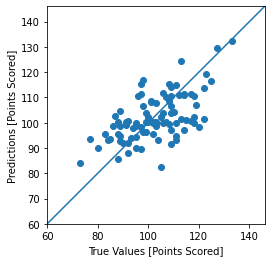

In [134]:
#make predictions and then plot them in realation to the actual values
test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel("True Values [Points Scored]")
plt.ylabel("Predictions [Points Scored]")
plt.axis('equal')
plt.axis('square')
plt.xlim([60, plt.ylim()[1]])
plt.ylim([60, plt.ylim()[1]])
_ = plt.plot([-100,200], [-100, 200])

In [135]:
#print test predictions
test_predictions

array([ 95.66026 ,  93.03352 ,  99.73904 ,  92.84356 ,  96.427284,
        94.698395,  93.668365,  90.10182 ,  88.043045, 100.847046,
       100.46582 , 102.80929 ,  85.46535 , 101.09071 , 100.120155,
        93.462585,  96.48985 ,  99.42241 ,  95.50708 ,  95.63265 ,
       102.11014 ,  93.16339 ,  91.92607 , 101.36909 ,  98.25298 ,
        94.0175  ,  94.48999 ,  96.9955  ,  91.82424 ,  97.7826  ,
        89.56866 , 102.417015,  99.714676,  98.809296, 100.43159 ,
        99.18296 ,  84.13124 ,  94.921135,  97.104485, 101.590546,
        99.84311 , 100.38008 ,  91.76251 ,  89.90087 , 100.39005 ,
        98.22171 , 100.13924 , 107.60454 , 104.23357 , 100.319885,
        93.1562  , 103.970436,  98.79297 ,  82.52289 , 104.64685 ,
       106.66585 , 111.129944, 103.92688 , 110.50752 , 102.34804 ,
       107.092255, 100.8098  , 114.95018 , 108.63892 ,  98.5815  ,
       106.52223 ,  98.63181 , 103.741035,  99.73944 ,  99.701454,
       110.94643 ,  99.49048 , 110.605865, 111.41106 , 119.461

In [136]:
#print test labels
test_labels

9       83
28      84
42      95
47      89
53      99
      ... 
850    109
852    108
862    101
880    127
896    113
Name: Points Scored, Length: 91, dtype: int64